## Import packages

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

import scripts.TextAnalysis as ta
import sklearn.cluster as cluster
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import plotly.express as px
from scripts.create_graph import *

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load all user tweets into a dataframe

In [68]:
fname_tweets = "data/@top3_user_tweets.csv"
df = pd.read_csv(fname_tweets)

print(f"We have {len(df)} tweets")
df.head()

We have 9563 tweets


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_Id,text,name,screen_name,UTC,created_at,favorites,retweet_count,language,client,tweet_type,urls,hashtags,mentions,media_type,media_urls,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1.380000e+18,"@dens Fun for me to watch, Adam pitched me and...",Rich Miner,richminer,2021-04-07T03:39:57.000Z,Wed Apr 07 03:39:57 +0000 2021,3,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Reply,NaN,0,1,NaN,NaN,NaN,NaN,NaN
1,1.380000e+18,"The sad thing is, LG was earlier in discussion...",Rich Miner,richminer,2021-04-07T01:16:00.000Z,Wed Apr 07 01:16:00 +0000 2021,6,1,en,"<a href=""http://twitter.com/download/android"" ...",Tweet,https://www.cnet.com/features/lg-once-out-ipho...,0,0,NaN,NaN,NaN,NaN,NaN
2,1.380000e+18,Congratulation @Kent_Walker &amp; team!! Huge ...,Rich Miner,richminer,2021-04-05T15:58:41.000Z,Mon Apr 05 15:58:41 +0000 2021,3,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tweet,https://twitter.com/Kent_Walker/status/1379089...,0,1,NaN,NaN,NaN,NaN,NaN
3,1.380000e+18,@mikefarb1 It makes you wonder why they hate o...,Rich Miner,richminer,2021-04-05T15:28:59.000Z,Mon Apr 05 15:28:59 +0000 2021,1,0,en,"<a href=""http://twitter.com/download/android"" ...",Reply,NaN,0,1,NaN,NaN,NaN,NaN,NaN
4,1.380000e+18,"As it should have, but huge win for investment...",Rich Miner,richminer,2021-04-05T15:25:27.000Z,Mon Apr 05 15:25:27 +0000 2021,9,1,en,"<a href=""http://twitter.com/download/android"" ...",Tweet,https://www.theverge.com/2021/4/5/22367851/goo...,0,0,NaN,NaN,NaN,NaN,NaN


### Construct retweet network


In [70]:
%%time
G = retweet_network_from_tweets(df)


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


went through 9563 tweets, found 0 retweets, 0 retweet edges
Retweet network has 0 nodes and 0 edges
Wall time: 552 ms


# Data Cleaning

In [74]:
df = df[ ['screen_name', 'text', 'retweet_count']]
df.sample(100).head()

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,screen_name,text,retweet_count
2905,richminer,RT @mollymcnearney : Hey @SenJohnMcCain -Thank...,0
7059,Jason,.@Chesaboudin doesn�t care about Asian people ...,3
5541,bfeld,Dumb money? � great post by @thegothamgal http...,2
2604,richminer,RT @inafried : @sundarpichai Well you could le...,0
2620,richminer,"Analysis | By not using Trump's name, his crit...",0


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='screen_name', ylabel='Count'>

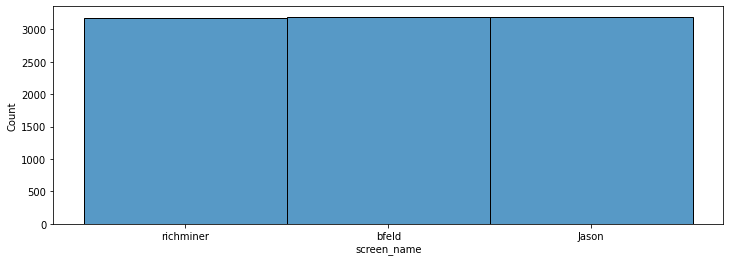

In [75]:
plt.figure(figsize=(12,4))
sns.histplot(data=df,x='screen_name')

In [76]:
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets
n0 = len(df)
df = df[df.text_clean.str.len() >0]  #remove cleaned tweets of lenght 0
nclean = len(df)
print(f"{n0} tweets, {nclean} clean tweets")

9563 tweets, 9487 clean tweets


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Convert Data into Vector Representation

### Term Frequency (TF) Vectorizer

We initialize the *CountVectorizer* and tell it to remove English stopwords with the *stop_words* parameter set to "english".  We also tell it to remove any word that occur in less than 5 documents with the *min_df* parameter.  Then we use the *fit_transform* method applied to the *text_clean* column of **df** to create the document vectors, which we call **tf_embedding**.  We store the words for each element of the vector in **tf_feature_names**.

In [78]:
tf_vectorizer = CountVectorizer(min_df=5, stop_words='english')
tf_embedding = tf_vectorizer.fit_transform(df.text_clean)
tf_feature_names = tf_vectorizer.get_feature_names()

nvocab = len(tf_feature_names)
ntweets = len(df.text_clean)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")

9487 tweets, 3841 words in vocabulary


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

We initialize the *TfidfVectorizer* as we did the *CountVectorizer*.  Then we use the *fit_transform* method applied to the *text_clean* column of **df** to create the document vectors, which we call **tfidf_embedding**.  We store the words for each element of the vector in **tfidf_feature_names**.

In [79]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_embedding = tfidf_vectorizer.fit_transform(df.text_clean)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

nvocab = len(tfidf_feature_names)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")

9487 tweets, 3841 words in vocabulary


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Cluster Tweets Using K-Means on TF and TF-IDF Vectors

We will cluster the tf and tf-idf vectors using the k-means algorithm.  We choose the number of clusters we want with the variable **n_clusters**.  To get the cluster label of each tweet we initiailize a *KMeans* object with the number of clusters, and then call the *fit_predict* function on **embedding_tf** and **embedding_tfidf**.  The cluster labels are in the variable **kmeans_label_tf** and **kmeans_label_tfidf**.  We add these labels to the dataframe **df** in a column with the same name.

In [82]:
%%time
#n_clusters = len(df.screen_name.unique())
n_clusters = 4
kmeans_label_tf = cluster.KMeans(n_clusters=n_clusters).fit_predict(tf_embedding)
df['kmeans_label_tf'] = [str(x) for x in kmeans_label_tf]


kmeans_label_tfidf = cluster.KMeans(n_clusters=n_clusters).fit_predict(tfidf_embedding)
df['kmeans_label_tfidf'] = [str(x) for x in kmeans_label_tfidf]


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 8.46 s


In [83]:
def kmeans_wordcloud_userhist(df, cluster_label_column,stopwords):
    print(cluster_label_column)
    for k in np.sort(df[cluster_label_column].unique()):
        s=df[df[cluster_label_column]==k]
        text=' '.join(s.text_clean.tolist()).lower()
        wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
        wordcloud.generate(text)
     
        print(f"\n\tCluster {k} {cluster_label_column} has {len(s)} tweets")
        plt.figure(figsize = (16,4))
        plt.subplot(1,2,1)
        ax = sns.histplot(data = s, x = 'screen_name')
        plt.xticks(rotation=45)
        plt.ylabel("Number of tweets")
        plt.xlabel("Screen name")

        plt.subplot(1,2,2)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return 1

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Histograms of Users and Word Clouds of Tweets in the Clusters

We will take the tweets in each cluster, make a word cloud for them, and a histogram of the screen names of the users who posted the tweets.  If we have good clusters, we expect one user to dominate each cluster, or a group of users who use tweet about similar topics.

We will be creating word clouds and histograms again later on, so lets write a function to do it.  The function is called *kmeans_wordcloud_userhist*.  Its inputs are the dataframe with the tweets and cluster labels, **df**, the name of the column with the cluster labels **cluster_label_column**, and a set of stopwords called **stopwords**.  

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


kmeans_label_tf

	Cluster 0 kmeans_label_tf has 574 tweets


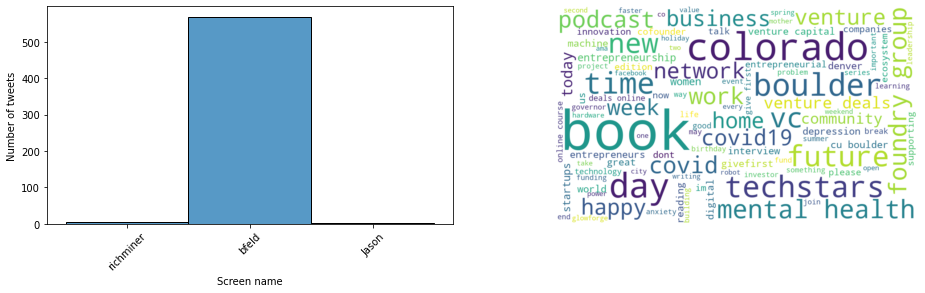


	Cluster 1 kmeans_label_tf has 610 tweets


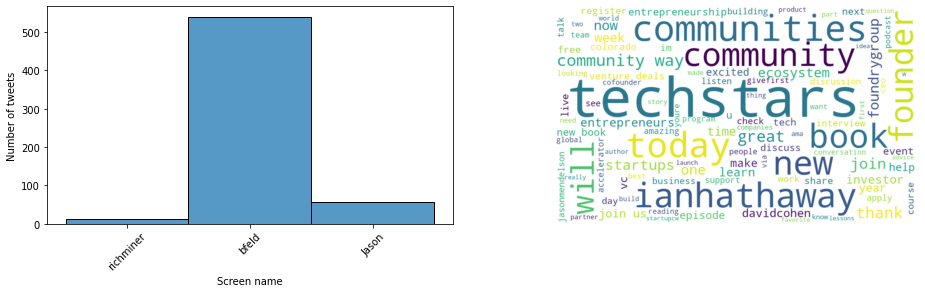


	Cluster 2 kmeans_label_tf has 76 tweets


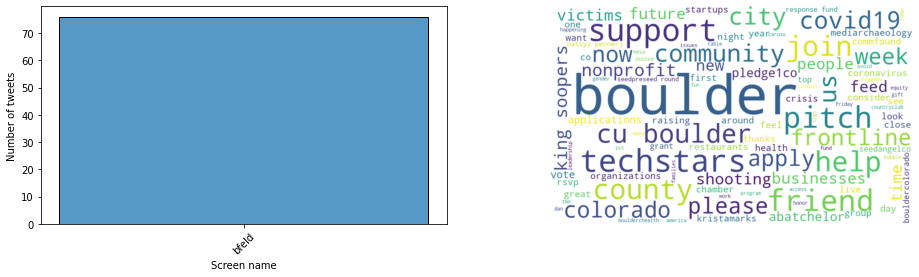


	Cluster 3 kmeans_label_tf has 8227 tweets


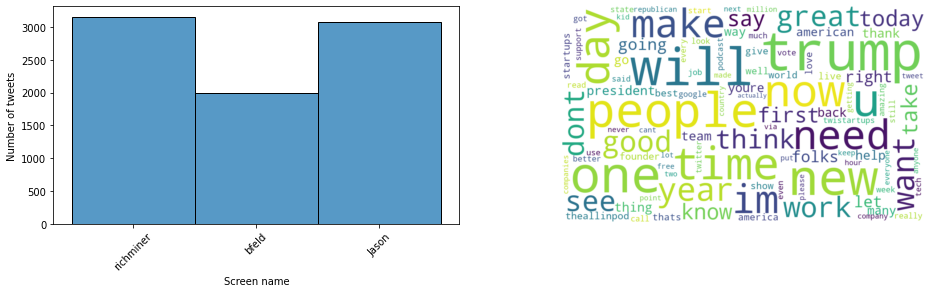

1

In [87]:
stopwords = set(STOPWORDS)
stopwords.add('feld')
stopwords.add('bfeld')
stopwords.add('brad')
stopwords.add('jason')
stopwords.add('richminer')
stopwords.add('thoughts')
stopwords.add('entrepreneur')
stopwords.add('startup')
cluster_label_column= 'kmeans_label_tf'
kmeans_wordcloud_userhist(df,cluster_label_column,stopwords )

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


kmeans_label_tfidf

	Cluster 0 kmeans_label_tfidf has 530 tweets


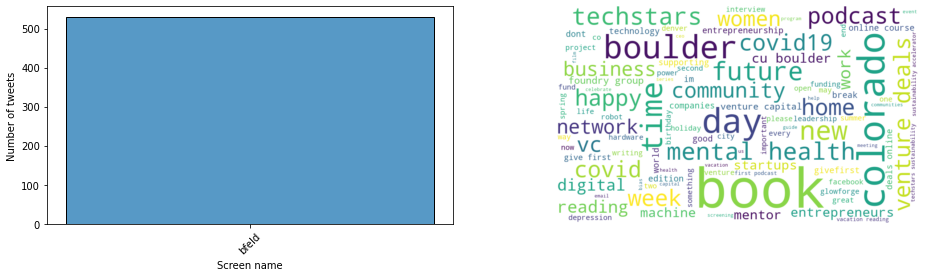


	Cluster 1 kmeans_label_tfidf has 534 tweets


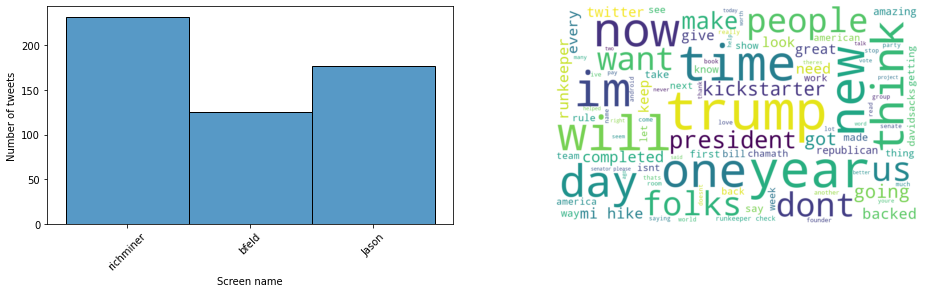


	Cluster 2 kmeans_label_tfidf has 505 tweets


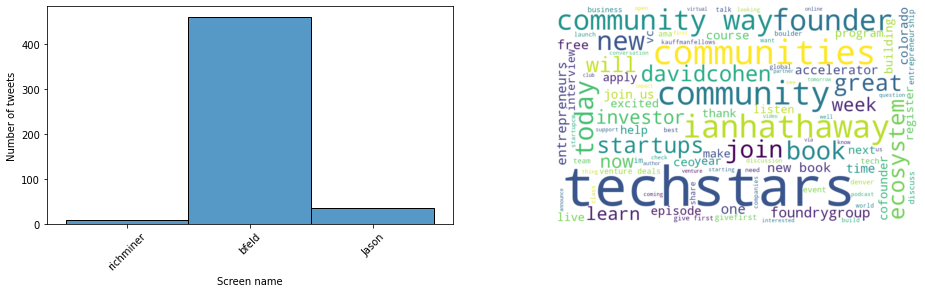


	Cluster 3 kmeans_label_tfidf has 7918 tweets


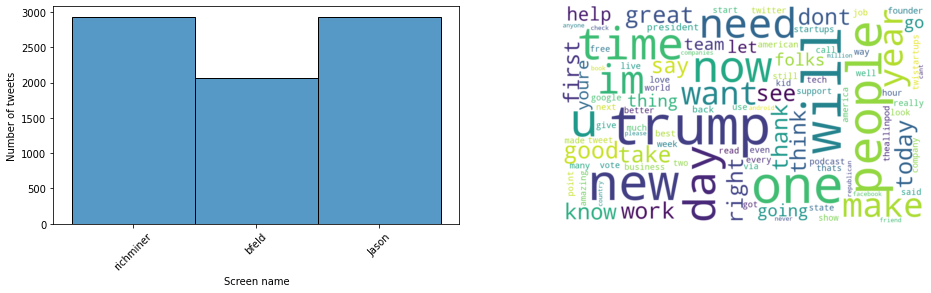

1

In [89]:
stopwords = set(STOPWORDS)
stopwords.add('feld')
stopwords.add('bfeld')
stopwords.add('brad')
stopwords.add('jason')
stopwords.add('richminer')
stopwords.add('thoughts')
stopwords.add('entrepreneur')
stopwords.add('startup')
cluster_label_column= 'kmeans_label_tfidf'
kmeans_wordcloud_userhist(df,cluster_label_column,stopwords )

In [90]:
%%time
num_topics = len(df.screen_name.unique())
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, 
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf_embedding)


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 7 s


In [91]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
print("LDA topics\n")
display_topics(lda, tf_feature_names, num_top_words)


LDA topics

Topic 1
new, thoughts, feld, techstars, year, week, founders, today, help, podcast
Topic 2
trump, people, dont, just, theallinpod, like, davidsacks, chamath, folks, want
Topic 3
startup, feld, thoughts, great, bfeld, time, jason, book, just, twistartups


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
viz = pyLDAvis.sklearn.prepare(lda, tf_embedding, tf_vectorizer)
pyLDAvis.display(viz)
#pyLDAvis.show(viz)

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Umap Embedding of the Vectorized Tweets

We use the *UMAP* function to compute the UMAP embeddings of the tf and tf-idf vectors.  The embedding for **tf_embedding** is **umap_tf_embedding** and the embedding for **tfidf_embedding** is **umap_tfidf_embedding**.  The UMAP embeddings contain the x and y coordiante of each tweet.

In [97]:
%%time
umap_tf_embedding = umap.UMAP(n_components=2, metric='hellinger').fit_transform(tf_embedding)

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JessZ\anaconda3\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 5748 edges.
It has only fully disconnected 165 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Wall time: 23.3 s


In [98]:
%%time
umap_tfidf_embedding = umap.UMAP(n_components=2, metric='hellinger').fit_transform(tfidf_embedding)

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JessZ\anaconda3\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 5074 edges.
It has only fully disconnected 172 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Wall time: 22.9 s


In [100]:
df['umap_tf_x'] = umap_tf_embedding[:,0]
df['umap_tf_y'] = umap_tf_embedding[:,1]
df['umap_tfidf_x'] = umap_tfidf_embedding[:,0]
df['umap_tfidf_y'] = umap_tfidf_embedding[:,1]


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


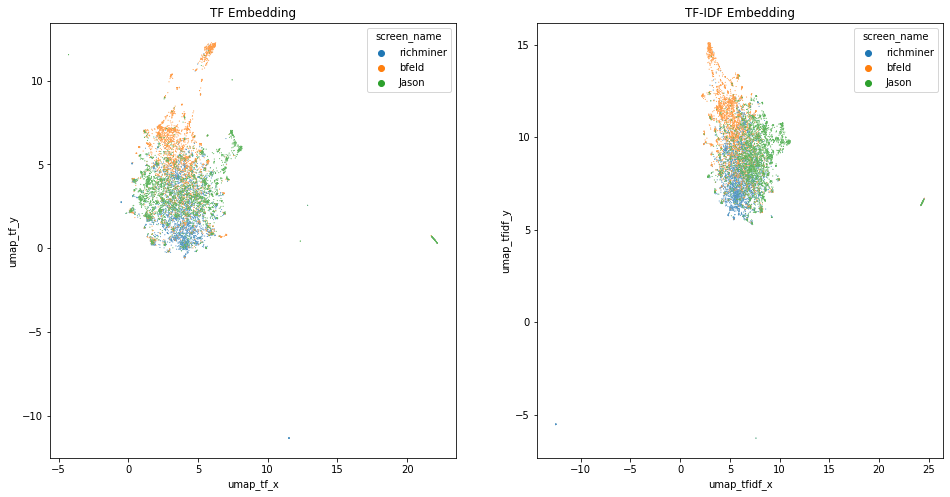

In [101]:
fig = plt.figure(figsize = (16,8))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(data=df, x="umap_tf_x", y="umap_tf_y", hue="screen_name", s=1)
plt.title("TF Embedding")

ax2 = plt.subplot(1,2,2)
sns.scatterplot(data=df, x="umap_tfidf_x", y="umap_tfidf_y", hue="screen_name", s=1)
plt.title("TF-IDF Embedding");
plt.show()

### Cluster Tweets Using UMAP Embedding

We can apply k-means clustering to the UMAP embeddings to cluster the tweets.  We will use the tfidf embedding here, but you can try the tf embedding in your free time.  The results should be similar.

The code below is similar to LDA.  We choose the number of clusters, **n_clusters**, and give the *fit_predict* method the embedding **umap_tfidf_embedding**.  There is one issue.  Sometimes the UMAP embedding produces NaN values, which k-means cannot use.  To fix this, we convert NaNs into zeros using the *nan_to_num* function.

After finding the cluster labels for the tweets, we add this as a column to **df** called *kmeans_label_umap*.  



In [102]:
%%time
n_clusters = len(df.screen_name.unique())

kmeans_label_umap = cluster.KMeans(n_clusters=n_clusters).fit_predict(np.nan_to_num(umap_tfidf_embedding))
df['kmeans_label_umap'] = [str(x) for x in kmeans_label_umap]


Wall time: 97.5 ms


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


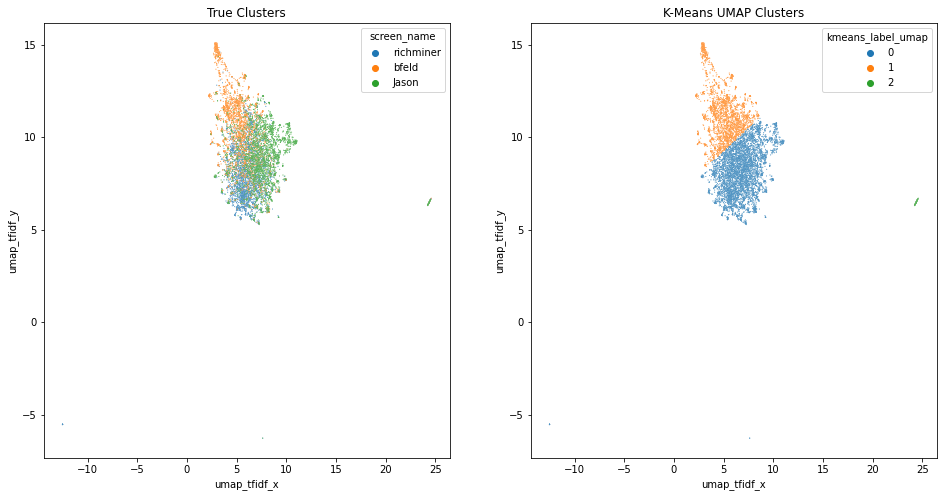

In [103]:
fig = plt.figure(figsize = (16,8))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(data=df, x="umap_tfidf_x", y="umap_tfidf_y", hue="screen_name", s=1)
plt.title("True Clusters")

ax2 = plt.subplot(1,2,2)
sns.scatterplot(data=df, x="umap_tfidf_x", y="umap_tfidf_y", hue="kmeans_label_umap", s=1)
plt.title("K-Means UMAP Clusters");
plt.show()

C:\Users\JessZ\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


kmeans_label_umap

	Cluster 0 kmeans_label_umap has 6128 tweets


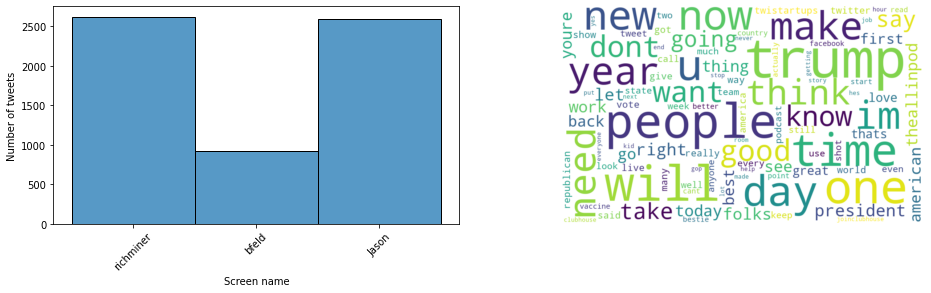


	Cluster 1 kmeans_label_umap has 3199 tweets


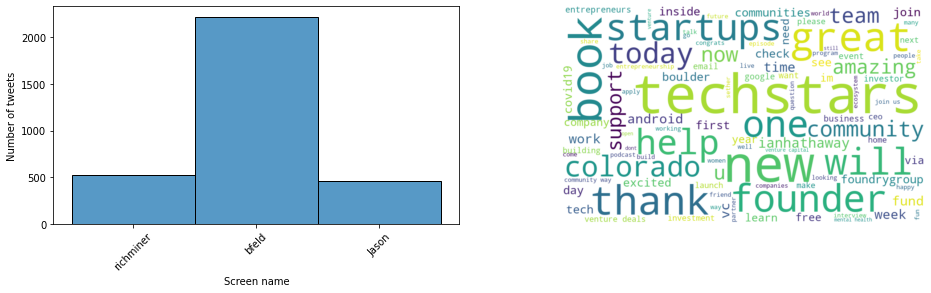


	Cluster 2 kmeans_label_umap has 160 tweets


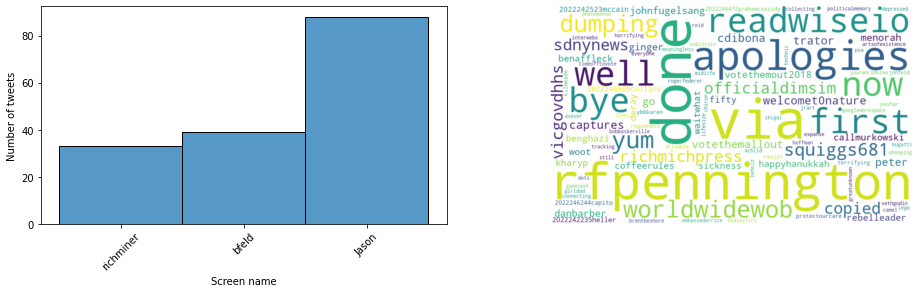

1

In [105]:
stopwords = set(STOPWORDS)
stopwords.add('feld')
stopwords.add('bfeld')
stopwords.add('brad')
stopwords.add('jason')
stopwords.add('richminer')
stopwords.add('thoughts')
stopwords.add('entrepreneur')
stopwords.add('startup')
cluster_label_column= 'kmeans_label_umap'
kmeans_wordcloud_userhist(df,cluster_label_column,stopwords )